# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'timegan_gru'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h       snow_1h  \
count   341988.000000  341988.000000  341988.000000  3.419880e+05   
mean      3145.712032     282.708035       0.050878  3.029690e-04   
std       1957.289369      11.932950       0.231161  6.406578e-04   
min         82.072840     247.054895       0.000000  0.000000e+00   
25%       1085.928718     272.528612       0.000005  4.559755e-08   
50%       3456.190720     284.139969       0.000045  4.407763e-07   
75%       4970.458088     293.249065       0.008492  2.847757e-04   
max       7044.640808     307.390251       6.059947  2.400404e-02   

          clouds_all  
count  341988.000000  
mean       43.593436  
std        38.827764  
min         0.125080  
25%         3.629832  
50%        29.905888  
75%        87.636451  
max        95.127577  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.08863472763448954
Training Loss: 0.07366199025884271
Training Loss: 0.06522385325282812
Validation Loss: 0.05902328007341771
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060029272455722094
Training Loss: 0.059002977441996333
Training Loss: 0.05545354207977653
Validation Loss: 0.04952130786907137
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05046120095998049
Training Loss: 0.048616191633045674
Training Loss: 0.044654579032212496
Validation Loss: 0.038613636716363135
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03937760570086539
Training Loss: 0.037104872884228826
Training Loss: 0.03328924313187599
Validation Loss: 0.02804206284495552
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.028656891477294267
Training Loss: 0.026706258407793938
Train

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:26<31:00, 206.69s/it]

Epoch: 1
Training Loss: 0.09081535119563341
Training Loss: 0.07914698392152786
Training Loss: 0.07149684697389602
Validation Loss: 0.06537680599964067
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06547037659212947
Training Loss: 0.063854717053473
Training Loss: 0.06037572786211967
Validation Loss: 0.05501592870843544
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05505059516057372
Training Loss: 0.052876309966668485
Training Loss: 0.0490362793020904
Validation Loss: 0.04350716882291135
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04340958275832236
Training Loss: 0.040799946403130886
Training Loss: 0.03690454519353807
Validation Loss: 0.03178304103150796
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03180908586829901
Training Loss: 0.029483146644197405
Training Loss

 20%|██        | 2/10 [06:49<27:16, 204.59s/it]

Training Loss: 0.006605631400598213
Validation Loss: 0.0034777749450144806
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.17192494969815017
Training Loss: 0.12639228258281945
Training Loss: 0.0944135607779026
Validation Loss: 0.0711755117171266
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07233495935797692
Training Loss: 0.0695561745390296
Training Loss: 0.06544756904244423
Validation Loss: 0.0563320272675391
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05755849815905094
Training Loss: 0.05465468612499535
Training Loss: 0.05005939659662545
Validation Loss: 0.04239680174361454
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04242222896777093
Training Loss: 0.039586785333231095
Training Loss: 0.03592935892753303
Validation Loss: 0.0306741539807467
Validation Accuracy: 

 30%|███       | 3/10 [10:13<23:49, 204.25s/it]

Training Loss: 0.0057143660465953875
Validation Loss: 0.002643452810772349
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7108155643939972
Training Loss: 0.5925090551376343
Training Loss: 0.4675715523958206
Validation Loss: 0.3252447619197074
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.27114350713789465
Training Loss: 0.1729871394485235
Training Loss: 0.11101485518738627
Validation Loss: 0.07239920206451683
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07367192370817065
Training Loss: 0.07059210646897554
Training Loss: 0.06826484540477396
Validation Loss: 0.06182697067937155
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0641938471607864
Training Loss: 0.06408203734084963
Training Loss: 0.0620757999829948
Validation Loss: 0.05632311779628979
Validation Accuracy: 0.0

 40%|████      | 4/10 [13:37<20:23, 203.98s/it]

Training Loss: 0.006059365033870563
Validation Loss: 0.003169776232170171
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.22221206698566676
Training Loss: 0.16054011948406696
Training Loss: 0.11282057292759419
Validation Loss: 0.07368061817094182
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07148460084572435
Training Loss: 0.06302097488194704
Training Loss: 0.05821917653083801
Validation Loss: 0.051843326455086804
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052897280789911745
Training Loss: 0.051318020913749936
Training Loss: 0.048183571975678206
Validation Loss: 0.04216894164179148
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04251903674565256
Training Loss: 0.040290172919631
Training Loss: 0.03702931047417223
Validation Loss: 0.0315213454364056
Validation Accura

 50%|█████     | 5/10 [17:00<16:59, 203.88s/it]

Training Loss: 0.005643699039937928
Validation Loss: 0.0026708881689884354
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.20978368803858757
Training Loss: 0.16507085751742123
Training Loss: 0.1161181634478271
Validation Loss: 0.06867272151487597
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06768371040001511
Training Loss: 0.062260447293519976
Training Loss: 0.05941793603822589
Validation Loss: 0.05246727838275138
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05546272985637188
Training Loss: 0.05506683446466923
Training Loss: 0.05256755578331649
Validation Loss: 0.04597803471044878
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.048138273982331156
Training Loss: 0.046982425497844815
Training Loss: 0.04377416498027742
Validation Loss: 0.03718059855314453
Validation Accu

 60%|██████    | 6/10 [20:24<13:34, 203.74s/it]

Epoch: 1
Training Loss: 0.5873366189002991
Training Loss: 0.4358617405593395
Training Loss: 0.28006333466619254
Validation Loss: 0.15364190475659423
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12148300228640437
Training Loss: 0.08535716386511921
Training Loss: 0.06759364765137434
Validation Loss: 0.058688168612758766
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05847994159907102
Training Loss: 0.05728627488017082
Training Loss: 0.05469087633304298
Validation Loss: 0.05117722341183866
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05104318119585514
Training Loss: 0.04959452553652227
Training Loss: 0.046517511820420625
Validation Loss: 0.042475001091200316
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.042070026053115724
Training Loss: 0.039914549896493554
Training L

 70%|███████   | 7/10 [23:47<10:10, 203.45s/it]

Training Loss: 0.005988435629406013
Validation Loss: 0.003141281405578922
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3521042294800282
Training Loss: 0.24587009578943253
Training Loss: 0.1444579726830125
Validation Loss: 0.081230715796184
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07859416643157602
Training Loss: 0.07281980842351914
Training Loss: 0.06972747897729277
Validation Loss: 0.06365192338321986
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06486494615674018
Training Loss: 0.06374599674716591
Training Loss: 0.060900919679552315
Validation Loss: 0.054706719358650485
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05561565374955535
Training Loss: 0.053827637862414124
Training Loss: 0.05034931410104036
Validation Loss: 0.043700873307632594
Validation Accurac

 80%|████████  | 8/10 [27:10<06:46, 203.39s/it]

Epoch: 1
Training Loss: 0.1857183063402772
Training Loss: 0.14713108949363232
Training Loss: 0.11045529123395681
Validation Loss: 0.07938783812556374
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07227817052975297
Training Loss: 0.06566313948482275
Training Loss: 0.06192853476852179
Validation Loss: 0.057676780717761326
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05689535053446889
Training Loss: 0.05551970667205751
Training Loss: 0.05219341066665947
Validation Loss: 0.04835829992642563
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04690134246833622
Training Loss: 0.045216874592006205
Training Loss: 0.042232309691607954
Validation Loss: 0.038810471826222506
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03745217530988157
Training Loss: 0.03553107148036361
Training L

 90%|█████████ | 9/10 [30:33<03:23, 203.34s/it]

Training Loss: 0.006562289661960676
Validation Loss: 0.0034657332188125405
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.33322284288704396
Training Loss: 0.25379672698676586
Training Loss: 0.17166539862751962
Validation Loss: 0.1022691817933254
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0888914461620152
Training Loss: 0.07579624228179455
Training Loss: 0.07086125805974007
Validation Loss: 0.06307827538988564
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06630447171628476
Training Loss: 0.06627279391512275
Training Loss: 0.0638963321223855
Validation Loss: 0.05625416196129295
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.058943438623100516
Training Loss: 0.05799720512703061
Training Loss: 0.05486408652737737
Validation Loss: 0.047102515596184835
Validation Accurac

100%|██████████| 10/10 [33:57<00:00, 203.39s/it]

Training Loss: 0.005850243708700873
Validation Loss: 0.002899003287076197
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [33:57<00:00, 203.73s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.13688391210511328
Training Loss: 0.0990920102596283
Training Loss: 0.07801425775513053
Validation Loss: 0.06874062853415361
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06633952368050813
Training Loss: 0.061375586949288845
Training Loss: 0.05981068836525082
Validation Loss: 0.0569299105973391
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05655574578791857
Training Loss: 0.05252892771735787
Training Loss: 0.05083735421299934
Validation Loss: 0.047584084731139495
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04725020452402532
Training Loss: 0.04293568143621087
Training Loss: 0.040444761766120794
Validation Loss: 0.036386886873188314
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03605384917929769
Training Loss: 0.031577778877690435
Training L

 10%|█         | 1/10 [03:25<30:48, 205.41s/it]

Validation Loss: 0.004181328086376065
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0914725155569613
Training Loss: 0.07650806616991758
Training Loss: 0.0718607504107058
Validation Loss: 0.07169002796826737
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06945252826437354
Training Loss: 0.06544395472854375
Training Loss: 0.06308607511222362
Validation Loss: 0.06227177544758561
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06008585760369897
Training Loss: 0.05546468686312437
Training Loss: 0.05228692576289177
Validation Loss: 0.0500030688250835
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04775333778932691
Training Loss: 0.04242913888767361
Training Loss: 0.03860933523625135
Validation Loss: 0.03534445792352885
Validation Accuracy: 0.0
********************************

 20%|██        | 2/10 [06:52<27:29, 206.13s/it]

Validation Loss: 0.004103366673395582
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5438265077769756
Training Loss: 0.42373119071125986
Training Loss: 0.309693681076169
Validation Loss: 0.19706765683681776
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1533841473981738
Training Loss: 0.09087961379438639
Training Loss: 0.06981237249448896
Validation Loss: 0.06666706973331028
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06512011479586363
Training Loss: 0.06099806537851691
Training Loss: 0.05902432562783361
Validation Loss: 0.05765814319504111
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056172274630516765
Training Loss: 0.05146553348749876
Training Loss: 0.04890613774769008
Validation Loss: 0.046485102358745055
Validation Accuracy: 0.0
*******************************

 30%|███       | 3/10 [10:18<24:04, 206.38s/it]

Validation Loss: 0.00318253211241498
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.21537626303732396
Training Loss: 0.15267224289476872
Training Loss: 0.10688933635130525
Validation Loss: 0.0801938267194488
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07364472119137645
Training Loss: 0.06595827070996166
Training Loss: 0.0627001416683197
Validation Loss: 0.06164637218449223
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06022102328017354
Training Loss: 0.05578969370573759
Training Loss: 0.05297895302996039
Validation Loss: 0.05129144620150328
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04985084997490048
Training Loss: 0.04506880464963615
Training Loss: 0.04200973936356604
Validation Loss: 0.03974548262659083
Validation Accuracy: 0.0
********************************

 40%|████      | 4/10 [13:50<20:51, 208.55s/it]

Validation Loss: 0.004228912677819935
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08036160496994853
Training Loss: 0.06740677254274488
Training Loss: 0.06390788171440363
Validation Loss: 0.06282374151888188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.061106330323964356
Training Loss: 0.05640768371522427
Training Loss: 0.05338411001488566
Validation Loss: 0.05066314540552289
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0487784119695425
Training Loss: 0.04325511404313147
Training Loss: 0.03975875004194677
Validation Loss: 0.03646162114618869
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03511375592090189
Training Loss: 0.030351240299642087
Training Loss: 0.02784054403193295
Validation Loss: 0.025569478327178218
Validation Accuracy: 0.0
***************************

 50%|█████     | 5/10 [17:35<17:52, 214.47s/it]

Validation Loss: 0.0036566643082939633
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3045731092989445
Training Loss: 0.2339725346118212
Training Loss: 0.1776869424805045
Validation Loss: 0.13345077864072297
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11209478497505188
Training Loss: 0.08141571573913098
Training Loss: 0.06876472128555179
Validation Loss: 0.066396290854959
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0638520442135632
Training Loss: 0.05964850841090083
Training Loss: 0.05764320310205221
Validation Loss: 0.05673951364718796
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05439223713241517
Training Loss: 0.049501416925340894
Training Loss: 0.046484350385144355
Validation Loss: 0.044563327068358326
Validation Accuracy: 0.0
*******************************

 60%|██████    | 6/10 [21:15<14:24, 216.20s/it]

Epoch: 1
Training Loss: 0.12825434854254125
Training Loss: 0.09392746949568391
Training Loss: 0.07374187743291259
Validation Loss: 0.0648971970789553
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06238999307155609
Training Loss: 0.057475938145071265
Training Loss: 0.055638031773269175
Validation Loss: 0.0535372823602363
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0523826033808291
Training Loss: 0.04741153462789953
Training Loss: 0.04468288077972829
Validation Loss: 0.041232498017338554
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04024220656603575
Training Loss: 0.034991767201572654
Training Loss: 0.032129749413579704
Validation Loss: 0.028894998797665487
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.02879064254462719
Training Loss: 0.02495319045614451
Training L

 70%|███████   | 7/10 [24:42<10:39, 213.16s/it]

Validation Loss: 0.0033404016671074407
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11046558089554309
Training Loss: 0.08603454202413559
Training Loss: 0.07384759079664946
Validation Loss: 0.06958629389743456
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06714917307719588
Training Loss: 0.06288200473412871
Training Loss: 0.06069574411958456
Validation Loss: 0.058628710468163654
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05739216852933168
Training Loss: 0.05340995498001575
Training Loss: 0.05105697819031775
Validation Loss: 0.048258518004852737
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.047324492456391455
Training Loss: 0.04326080825179815
Training Loss: 0.04059709068387747
Validation Loss: 0.03718956409210569
Validation Accuracy: 0.0
*************************

 80%|████████  | 8/10 [28:08<07:02, 211.17s/it]

Validation Loss: 0.003986671330862459
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3150397735089064
Training Loss: 0.2528109987080097
Training Loss: 0.19374139726161957
Validation Loss: 0.13955470835894682
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11893792148679495
Training Loss: 0.08340919451788067
Training Loss: 0.06737136241048575
Validation Loss: 0.06274613767360034
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06116073228418827
Training Loss: 0.05705577831715345
Training Loss: 0.05563156584277749
Validation Loss: 0.05531033111757107
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054131802171468735
Training Loss: 0.050114148547872904
Training Loss: 0.04806566921062767
Validation Loss: 0.04680048965252517
Validation Accuracy: 0.0
*****************************

 90%|█████████ | 9/10 [31:36<03:29, 209.96s/it]

Validation Loss: 0.002978108968491551
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5274981701374054
Training Loss: 0.4422242744266987
Training Loss: 0.3611847373098135
Validation Loss: 0.28774900625595884
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2421060661226511
Training Loss: 0.16580703381448983
Training Loss: 0.11005162851884961
Validation Loss: 0.08003323271954327
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06915118562057615
Training Loss: 0.05948451355099678
Training Loss: 0.057519886270165445
Validation Loss: 0.05658428827196025
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05610230783000589
Training Loss: 0.05354196835309267
Training Loss: 0.05300639766268432
Validation Loss: 0.051822402242445546
Validation Accuracy: 0.0
*******************************

100%|██████████| 10/10 [35:02<00:00, 210.28s/it]


Validation Loss: 0.0034471014553806587
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.1294358115270734
Training Loss: 0.09826961673796177
Training Loss: 0.0812670280970633
Validation Loss: 0.069566473947557
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06527694715186953
Training Loss: 0.060924400109797716
Training Loss: 0.056373101677745584
Validation Loss: 0.05260122640256109
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049747123047709466
Training Loss: 0.045390913113951686
Training Loss: 0.0406231465563178
Validation Loss: 0.036677615363254895
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03447595270350576
Training Loss: 0.030312716900371014
Training Loss: 0.026294223251752555
Validation Loss: 0.02277909247100603
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.021538788648322225
Training Loss: 0.018528767039533704
Training 

 10%|█         | 1/10 [03:24<30:41, 204.57s/it]

Validation Loss: 0.00404154575057848
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.41780985087156297
Training Loss: 0.2827757734060288
Training Loss: 0.19001309506595135
Validation Loss: 0.13220632925379874
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11541289158165455
Training Loss: 0.10008465578779578
Training Loss: 0.08973541552200913
Validation Loss: 0.0831071489266843
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07747857350856066
Training Loss: 0.0698209098353982
Training Loss: 0.06067772671580315
Validation Loss: 0.05315703122392713
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04870159722864628
Training Loss: 0.041835267208516595
Training Loss: 0.036538106314837934
Validation Loss: 0.03284455528846999
Validation Accuracy: 0.0
*******************************

 20%|██        | 2/10 [06:49<27:17, 204.69s/it]

Validation Loss: 0.004201791418310483
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.39403154209256175
Training Loss: 0.28883563794195655
Training Loss: 0.20846372485160827
Validation Loss: 0.1399764578435674
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11764702782034873
Training Loss: 0.09303958492353559
Training Loss: 0.08468074534088373
Validation Loss: 0.08183825255356021
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07896604523062706
Training Loss: 0.07746266659349203
Training Loss: 0.07439728524535895
Validation Loss: 0.07286330535175414
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07012151716277003
Training Loss: 0.06792449235916137
Training Loss: 0.06400252049788832
Validation Loss: 0.06108624623391215
Validation Accuracy: 0.0
******************************

 30%|███       | 3/10 [10:13<23:51, 204.56s/it]

Validation Loss: 0.004213643979603768
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.16888973820954561
Training Loss: 0.11951658438891172
Training Loss: 0.09021953577175737
Validation Loss: 0.07294255763542053
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0668964552693069
Training Loss: 0.06094786500558257
Training Loss: 0.05538188831880689
Validation Loss: 0.05211575653965913
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049322750652208924
Training Loss: 0.045538779916241764
Training Loss: 0.040643830075860025
Validation Loss: 0.037290609030666964
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03509681724011898
Training Loss: 0.03129298897460103
Training Loss: 0.027452709022909402
Validation Loss: 0.024768649433952804
Validation Accuracy: 0.0
************************

 40%|████      | 4/10 [13:38<20:28, 204.81s/it]

Validation Loss: 0.004080391945525504
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08775101294741035
Training Loss: 0.08063958378508687
Training Loss: 0.07685159295797347
Validation Loss: 0.0741730028732196
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07151564927771688
Training Loss: 0.06830900987610221
Training Loss: 0.06431117942556738
Validation Loss: 0.060857537301392525
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05816913390532136
Training Loss: 0.05376097371801734
Training Loss: 0.0491750456020236
Validation Loss: 0.04500568810038726
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04264081748202443
Training Loss: 0.03781443523243069
Training Loss: 0.03399472671560943
Validation Loss: 0.0307039845131296
Validation Accuracy: 0.0
*******************************

 50%|█████     | 5/10 [17:03<17:03, 204.72s/it]

Validation Loss: 0.00432802964126764
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15105944409966468
Training Loss: 0.11178578551858663
Training Loss: 0.0862609090283513
Validation Loss: 0.07252129872834216
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06808731304481626
Training Loss: 0.06453014638274908
Training Loss: 0.05979961315169931
Validation Loss: 0.05638013068357659
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0535014184191823
Training Loss: 0.049914738675579426
Training Loss: 0.04494622392579913
Validation Loss: 0.041126875560626636
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.038794857943430544
Training Loss: 0.03499438629485667
Training Loss: 0.030900943111628294
Validation Loss: 0.027852467526603676
Validation Accuracy: 0.0
***************************

 60%|██████    | 6/10 [20:28<13:38, 204.74s/it]

Validation Loss: 0.004245935843648733
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1564166685938835
Training Loss: 0.11633196201175451
Training Loss: 0.09474963299930096
Validation Loss: 0.08090282435523731
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07598715474829078
Training Loss: 0.07259930150583387
Training Loss: 0.06963508607819677
Validation Loss: 0.067418304402069
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06467001123353838
Training Loss: 0.06177752075716853
Training Loss: 0.057149987407028674
Validation Loss: 0.05254087636673917
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049204996041953566
Training Loss: 0.04405585303902626
Training Loss: 0.038585885670036076
Validation Loss: 0.03394741458849534
Validation Accuracy: 0.0
*****************************

 70%|███████   | 7/10 [23:52<10:14, 204.67s/it]

Validation Loss: 0.004224660831071728
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.24962590545415878
Training Loss: 0.19071876239031554
Training Loss: 0.1433502586185932
Validation Loss: 0.10038906452376083
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08880341451615095
Training Loss: 0.08107538463547825
Training Loss: 0.07680585460737348
Validation Loss: 0.07447489222001763
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07143361952155829
Training Loss: 0.06837287677451968
Training Loss: 0.06359613489359617
Validation Loss: 0.05982523836070599
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05652975494042039
Training Loss: 0.05166408626362681
Training Loss: 0.04568296803161502
Validation Loss: 0.040366155319123964
Validation Accuracy: 0.0
*****************************

 80%|████████  | 8/10 [27:18<06:49, 204.91s/it]

Validation Loss: 0.004315735024982783
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.13007548794150353
Training Loss: 0.10204783372581006
Training Loss: 0.09075163658708334
Validation Loss: 0.08617771021480666
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0831893303245306
Training Loss: 0.08132826713845134
Training Loss: 0.07854633392766118
Validation Loss: 0.07710788592529697
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07488243006169797
Training Loss: 0.0731654091924429
Training Loss: 0.07060407446697355
Validation Loss: 0.0686929733102215
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0664151555672288
Training Loss: 0.0637335216253996
Training Loss: 0.06028856210410595
Validation Loss: 0.056906140778817275
Validation Accuracy: 0.0
*********************************

 90%|█████████ | 9/10 [30:43<03:24, 204.95s/it]

Validation Loss: 0.004263118516221934
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.247563781067729
Training Loss: 0.1682568470016122
Training Loss: 0.12263731516897679
Validation Loss: 0.08706002058097104
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07441212764009833
Training Loss: 0.05936442272737622
Training Loss: 0.05269457506015897
Validation Loss: 0.04936609227813822
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.047205710615962744
Training Loss: 0.04419754926115274
Training Loss: 0.041001612665131686
Validation Loss: 0.03872833486292615
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.037239335225895044
Training Loss: 0.03423198784701526
Training Loss: 0.03168081996962428
Validation Loss: 0.029713623985315168
Validation Accuracy: 0.0
****************************

100%|██████████| 10/10 [34:07<00:00, 204.79s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.14928318701684476
Training Loss: 0.09999883778393269
Training Loss: 0.07241328591480851
Training Loss: 0.061429499033838514
Training Loss: 0.0583735722489655
Training Loss: 0.05610096782445908
Training Loss: 0.05371073907241225
Validation Loss: 0.053067950315578157
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05555944019928574
Training Loss: 0.05264477561227977
Training Loss: 0.05017633247189224
Training Loss: 0.04617020622827113
Training Loss: 0.04209075903519988
Training Loss: 0.03895067890174687
Training Loss: 0.0359032668825239
Validation Loss: 0.03553156609810917
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03929866564460099
Training Loss: 0.03571353634819388
Training Loss: 0.033298755157738925
Training Loss: 0.02857058683875948
Training Loss: 0.023063365719281137
Training Loss: 0.020170727176591755
Training Loss: 0.017988704782910644
Validati

 10%|█         | 1/10 [06:41<1:00:10, 401.21s/it]

Training Loss: 0.004546403876738623
Validation Loss: 0.004662331437852499
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14734725773334503
Training Loss: 0.11954408090561629
Training Loss: 0.09538921689614653
Training Loss: 0.0759877735003829
Training Loss: 0.06591701323166489
Training Loss: 0.060568319950252775
Training Loss: 0.05764848988503218
Validation Loss: 0.056293775512372954
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05738390259444714
Training Loss: 0.05361327474936843
Training Loss: 0.05039037507027388
Training Loss: 0.045187690509483215
Training Loss: 0.03909305663779378
Training Loss: 0.033992205439135434
Training Loss: 0.03026933642104268
Validation Loss: 0.030480513195699072
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03514889371115714
Training Loss: 0.030311697502620517
Training Loss: 0.027437533088959

 20%|██        | 2/10 [13:22<53:32, 401.54s/it]  

Training Loss: 0.004585976028465666
Validation Loss: 0.004682836094906044
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.25797427505254744
Training Loss: 0.20000432904809715
Training Loss: 0.14163180273026227
Training Loss: 0.0895137682184577
Training Loss: 0.06115806372836232
Training Loss: 0.05216700920835137
Training Loss: 0.049197480976581574
Validation Loss: 0.04916685350825278
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05352961855940521
Training Loss: 0.049980301791802045
Training Loss: 0.047415393833070994
Training Loss: 0.041804905757308004
Training Loss: 0.03565850516781211
Training Loss: 0.03211678490042687
Training Loss: 0.02934923709370196
Validation Loss: 0.030448235466741445
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.037008691504597666
Training Loss: 0.033053656141273674
Training Loss: 0.03095936914905

 30%|███       | 3/10 [20:04<46:49, 401.42s/it]

Training Loss: 0.004393702591769398
Validation Loss: 0.004439909925879666
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.48519487366080283
Training Loss: 0.3645550601929426
Training Loss: 0.22187925882637502
Training Loss: 0.11732994332909584
Training Loss: 0.0877330624870956
Training Loss: 0.082118102312088
Training Loss: 0.07895548718050122
Validation Loss: 0.0758676075756773
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07551457021385431
Training Loss: 0.07348460890352726
Training Loss: 0.07084852473810316
Training Loss: 0.06904969055205584
Training Loss: 0.06855973340570927
Training Loss: 0.06595670899376273
Training Loss: 0.06285721039399504
Validation Loss: 0.06064414915241552
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06134838504716754
Training Loss: 0.05870202410966158
Training Loss: 0.055879323035478594
Traini

 40%|████      | 4/10 [26:45<40:07, 401.25s/it]

Training Loss: 0.004501869294908829
Validation Loss: 0.004663860441921523
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.49837839022278785
Training Loss: 0.3804254225641489
Training Loss: 0.23876304451376199
Training Loss: 0.12605022704228758
Training Loss: 0.07801958484575153
Training Loss: 0.06439170941710472
Training Loss: 0.05958391414955258
Validation Loss: 0.05951146166143793
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06369870210066438
Training Loss: 0.05994051864370704
Training Loss: 0.057019493468105795
Training Loss: 0.052056800164282324
Training Loss: 0.04647355518303811
Training Loss: 0.04320682320743799
Training Loss: 0.03971797689795494
Validation Loss: 0.04068300988148438
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04579049302265048
Training Loss: 0.04171713953837752
Training Loss: 0.039071834813803434


 50%|█████     | 5/10 [31:30<29:57, 359.58s/it]

Training Loss: 0.004737842463655397
Validation Loss: 0.0045704273275912425
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 142
Early stopping after 142 epochs
Epoch: 1
Training Loss: 0.7156729310750961
Training Loss: 0.5806214641034603
Training Loss: 0.4418613962829113
Training Loss: 0.2914422069489956
Training Loss: 0.17029194451868535
Training Loss: 0.10761306505650282
Training Loss: 0.07939255259931087
Validation Loss: 0.06922211591503147
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06998424226418137
Training Loss: 0.06250337468460203
Training Loss: 0.05875596832484007
Training Loss: 0.05642537506297231
Training Loss: 0.05438821649178863
Training Loss: 0.051433518286794426
Training Loss: 0.04721736589446664
Validation Loss: 0.04560785979897565
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04912714122794568
Training Loss: 0.04618917881511152
Trainin

 60%|██████    | 6/10 [38:14<24:58, 374.69s/it]

Training Loss: 0.004437912295688875
Validation Loss: 0.0043188175770771525
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15047804299741985
Training Loss: 0.11399454165250063
Training Loss: 0.09292888728901744
Training Loss: 0.08079405903816222
Training Loss: 0.07737508922815323
Training Loss: 0.07505522845312954
Training Loss: 0.07421528721228242
Validation Loss: 0.07340969258312428
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07553599700331688
Training Loss: 0.07289302799850703
Training Loss: 0.07084575966000557
Training Loss: 0.06770250482484698
Training Loss: 0.06561097471043467
Training Loss: 0.06252254474908113
Training Loss: 0.0599950709939003
Validation Loss: 0.058760486780369325
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06142931301146746
Training Loss: 0.05714214297011495
Training Loss: 0.05347335271537304
T

 70%|███████   | 7/10 [44:58<19:12, 384.05s/it]

Training Loss: 0.0045977061183657495
Validation Loss: 0.0048206643265068586
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14441183749586345
Training Loss: 0.10238853152841329
Training Loss: 0.07416598448529839
Training Loss: 0.05857053119689226
Training Loss: 0.05274256508797407
Training Loss: 0.04919169217348099
Training Loss: 0.04540618419647217
Validation Loss: 0.04374864829306522
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.045135707585141065
Training Loss: 0.041415521893650296
Training Loss: 0.03847441968508065
Training Loss: 0.033954539187252525
Training Loss: 0.028416069969534875
Training Loss: 0.024663284085690976
Training Loss: 0.021836464898660778
Validation Loss: 0.022438681897208487
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.027507436540909112
Training Loss: 0.02445562057197094
Training Loss: 0.0231623443

 80%|████████  | 8/10 [48:24<10:54, 327.46s/it]

Training Loss: 0.00468899474828504
Validation Loss: 0.004761473019345758
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 103
Early stopping after 103 epochs
Epoch: 1
Training Loss: 0.41113042771816255
Training Loss: 0.30880892485380174
Training Loss: 0.20345492828637363
Training Loss: 0.11969034224748612
Training Loss: 0.07779900861904025
Training Loss: 0.0630032442882657
Training Loss: 0.05761674022302032
Validation Loss: 0.056301367598191626
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060117167178541424
Training Loss: 0.056941888369619845
Training Loss: 0.05421181509271264
Training Loss: 0.050054425932466985
Training Loss: 0.04556785115040839
Training Loss: 0.042394697042182086
Training Loss: 0.039169526938349006
Validation Loss: 0.03897617000402806
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04364989531226456
Training Loss: 0.040185905806720254


 90%|█████████ | 9/10 [52:41<05:05, 305.56s/it]

Training Loss: 0.004941559300059453
Validation Loss: 0.004956148481973157
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 128
Early stopping after 128 epochs
Epoch: 1
Training Loss: 0.1135581192187965
Training Loss: 0.07861820716410875
Training Loss: 0.06243479000404477
Training Loss: 0.05627194946631789
Training Loss: 0.05381500504910946
Training Loss: 0.050336019713431594
Training Loss: 0.04630839927121997
Validation Loss: 0.04413174639703629
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.045187570806592706
Training Loss: 0.04085996615700424
Training Loss: 0.037213529981672766
Training Loss: 0.03193481581751257
Training Loss: 0.0253037060983479
Training Loss: 0.021059024794958532
Training Loss: 0.018281480837613343
Validation Loss: 0.01945933440442054
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.025491864471696317
Training Loss: 0.02248323507141322
T

100%|██████████| 10/10 [59:24<00:00, 356.42s/it]

Training Loss: 0.004404687143396586
Validation Loss: 0.0045847826727146235
Validation Accuracy: 0.0
**************************************************


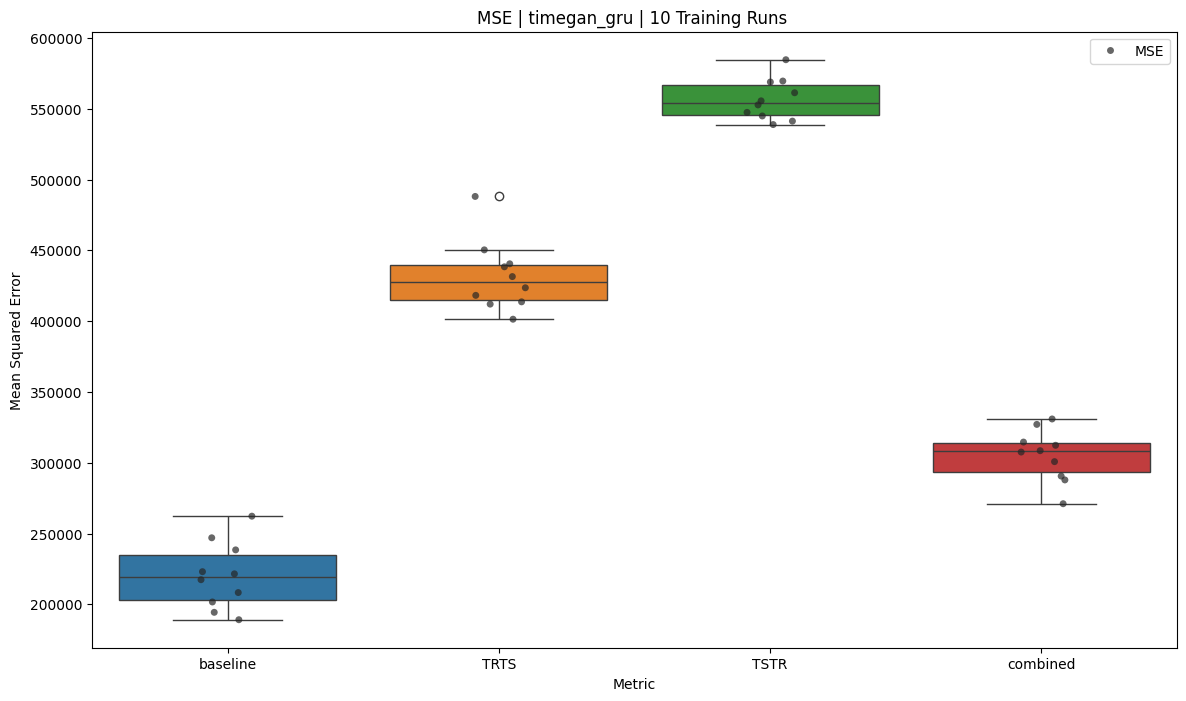

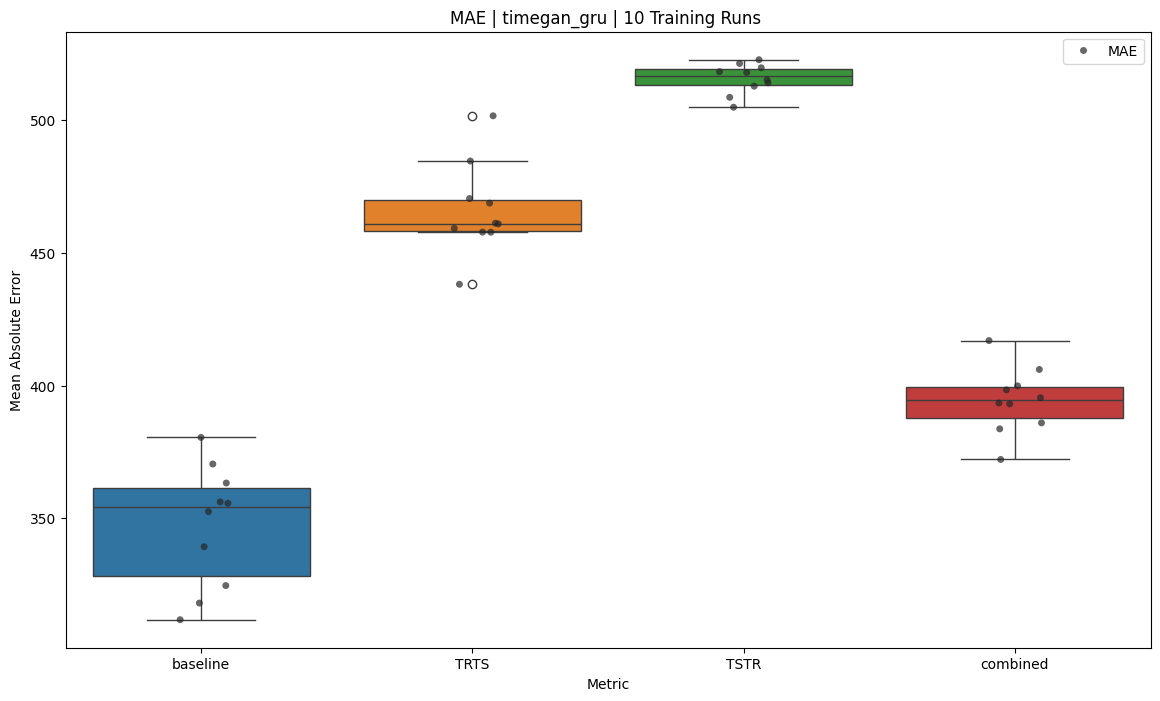

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [9]:
0.2*1e06

200000.0